## Machine Learning Project: Japanese Vowel speaker classification

### Importing data into time series arrays 

In [1]:
import numpy as np
import pandas as pd
import copy

In [2]:
# importing data sets
trainData = np.loadtxt("ae.train")
testData = np.loadtxt("ae.test")

#### Overview: 
* Training: 270 (30 utterances by 9 speakers. See file 'size_ae.train'.) 
* Testing: 370 (24-88 utterances by the same 9 speakers in different opportunities. See file 'size_ae.test'.) 

### Input Formatting

In [3]:
# obtaining 270 training time series arrays
# arrays are (N x 12); where N is length of time series recording and 12 is number of dimensions (ie channels)
trainInputs = np.empty((270,1), dtype=object)
readindex = 0

for i in range(1,271):
    readindex = readindex + 1  
    l = 0
    while trainData[readindex-1, 1] != 1:
        l = l + 1 
        readindex = readindex + 1
    trainInputs[i-1,0] = trainData[readindex-l-1:readindex-1,:]


# obtaining 370 test time series arrays 
# arrays are (N x 12); where N is length of time series recording and 12 is number of dimensions (ie channels)
testInputs = np.empty((370,1), dtype=object)
readindex = 0

# The last 12 entries of each recording are 1s, indicating 12 channels
# They are droppped when reading in the data
for i in range(1,371):
    readindex = readindex + 1
    l = 0 
    while testData[readindex-1, 1] != 1:
        l = l+1 
        readindex = readindex + 1
    testInputs[i-1,0] = testData[readindex-l-1:readindex-1,:] 

In [4]:
# obtaining 270 training outputs (speaker targets)
# arrays are (N x 9); where N is length of time series recording and 9 is number of different speakers
# the speaker is indicated with a '1'
trainOutputs = np.empty((270,1), dtype=object)

for i in range(1,271):
    l = np.size(trainInputs[i-1,0],0)
    teacher = np.zeros((l,9))
    speakerIndex = np.ceil(i/30)
    teacher[:,np.int(speakerIndex)-1] = 1 
    trainOutputs[i-1,0] = teacher

# obtaining 370 test outputs (speaker targets)
# arrays are (N x 9); where N is length of time series recording and 9 is number of different speakers
# the speaker is indicated with a '1'
testOutputs = np.empty((370,1), dtype=object)
speakerIndex = 1
blockCounter = 0
blockLengthes = [31, 35, 88, 44, 29, 24, 40, 50, 29]
for i in range(1, 371):
    blockCounter = blockCounter + 1 
    if blockCounter == blockLengthes[speakerIndex-1] + 1:
        speakerIndex = speakerIndex + 1
        blockCounter = 1
    l = np.size(testInputs[i-1,0], 0)
    teacher = np.zeros((l,9))
    teacher[:,np.int(speakerIndex)-1] = 1   
    testOutputs[i-1, 0] = teacher

### Transforms the trainOutputs & testOutputs in classes 1-9

In [5]:
# Transforms the trainOutputs in classes 1-9
trainOutputsNew = np.empty((270,1), dtype=object)
idxx = 0
for elements in trainOutputs:
    for i in range(len(elements[0][0])):
       if elements[0][0][i] == 1:
           trainOutputsNew[idxx] = i + 1
           idxx = idxx + 1
        
trainOutputsNew = np.ravel(trainOutputsNew)
trainOutputsNew = trainOutputsNew.astype('int')

# Transform the testOutputs in classes 1 - 9
testOutputsNew = np.empty((370,1), dtype=object)
idxx = 0
for elements in testOutputs:
    for i in range(len(elements[0][0])):
       if elements[0][0][i] == 1:
           testOutputsNew[idxx] = i + 1
           idxx = idxx + 1
        
testOutputsNew = np.ravel(testOutputsNew)
testOutputsNew = testOutputsNew.astype('int')

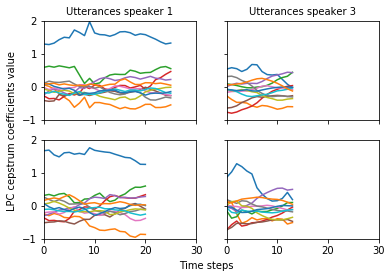

In [6]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


fig, axs = plt.subplots(2, 2)
#fig.suptitle('Examples from the Japanese Vowels dataset', y = 1)
axs[0, 0].plot(trainInputs[1, 0])
axs[0, 0].set_title('Utterances speaker 1', fontsize = 10)
axs[0, 0].set_xlim(0, 30)
axs[0, 0].set_ylim(-1, 2)

axs[0, 1].plot(trainInputs[62, 0])
axs[0, 1].set_title('Utterances speaker 3', fontsize = 10)
axs[0, 1].set_xlim(0, 30)
axs[0, 1].set_ylim(-1, 2)

axs[1, 0].plot(trainInputs[4, 0])
axs[1, 0].set_xlim(0, 30)
axs[1, 0].set_ylim(-1, 2)

axs[1, 1].plot(trainInputs[64, 0])
axs[1, 1].set_xlim(0, 30)
axs[1, 1].set_ylim(-1, 2)

fig.text(0.04, 0.5, 'LPC cepstrum coefficients value', va='center', rotation='vertical')
fig.text(0.5, 0.02, 'Time steps', ha='center')


#for ax in axs.flat:
#    ax.set(xlabel='Time steps')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.show()

fig.savefig('speaker_plot2.pdf')  

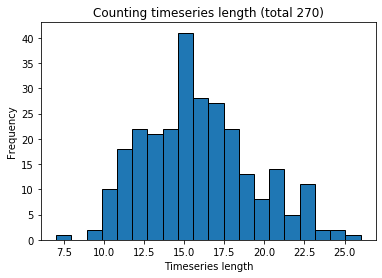

In [7]:
# Prints histogram of timeseries length (exploratory analysis)
import matplotlib.pyplot as plt

histos = np.zeros(270)

for i in range(270):
    histos[i] = (len(trainInputs[i, 0]))

#print(histos)
plt.title('Counting timeseries length (total 270)')
plt.xlabel('Timeseries length')
plt.ylabel('Frequency')
plt.hist(histos, bins = 20, ec='black')
plt.show()

### Add length of each recording as a feature

In [8]:
# Add length of each recording for TRAINING data 
# ----------------------------------------------

testLen = np.zeros(370)

for i in range(270):
    testLen[i] = len(trainInputs[i, 0]) / 26
#print(RecordingLength)

for i in range(270):
    lenArray = len(trainInputs[i][0])
    rec = np.full(lenArray, testLen[i])
    newArray = np.column_stack((trainInputs[i][0][:], rec))
    trainInputs[i][0] = newArray

# Add length of each recording for TESTING data 
# ----------------------------------------------

trainLen = np.zeros(370)
# Maximum Length is 29
for i in range(370):
    trainLen[i] = len(testInputs[i, 0]) / 29

for i in range(370):
    lenArray = len(testInputs[i][0])
    rec = np.full(lenArray, trainLen[i])
    newArray = np.column_stack((testInputs[i][0][:], rec))
    testInputs[i][0] = newArray

## Data Preprocessing: Polynomial approximation (training and testing)¶

### 1) Flattening & Reshaping the Test Data and Training Data. Both are padded using PREpadding. Padding is dropped in the polynomial approximation phase

In [9]:
#------ For TRAINING data ------------------------------

size_train = 13 * 26
PrePaddingTrain = np.empty((270,size_train), dtype=object)
PostPaddingTrain = np.empty((270,size_train), dtype=object)

idx = 0 
for element in trainInputs:
    # Flatten
    element = np.ndarray.flatten(element[0])
    # Pad zeros before  
    elements = element
    elements = np.pad(elements, (size_train - len(elements), 0), 'constant')
    PrePaddingTrain[idx] = elements

    # Pad zeros after
    shape = np.shape(element)
    padded_array = np.zeros(size_train)
    padded_array[:shape[0]] = element  
    element = padded_array
    PostPaddingTrain[idx] = element
    idx = idx + 1

# Reshape ---------------------------------------------
PrePaddingTrain = PrePaddingTrain.reshape(270, 26, 13)
PostPaddingTrain = PostPaddingTrain.reshape(270, 26, 13)

#------ For TESTING data ------------------------------

size_test = 13 * 29
PrePaddingTest = np.empty((370,size_test), dtype=object)
PostPaddingTest = np.empty((370,size_test), dtype=object)

idx = 0 
for element in testInputs:
    # Flatten
    element = np.ndarray.flatten(element[0])
    # Pad zeros before
    # ----------------
    elements = element
    elements = np.pad(elements, (size_test - len(elements), 0), 'constant')
    PrePaddingTest[idx] = elements

    # Pad zeros after
    # --------------
    shape = np.shape(element)
    padded_array = np.zeros(size_test)
    padded_array[:shape[0]] = element  
    element = padded_array
    PostPaddingTest[idx] = element
    idx = idx + 1

# Reshape -------------------------------------------
PrePaddingTest = PrePaddingTest.reshape(370, 29, 13)
PostPaddingTest = PostPaddingTest.reshape(370, 29, 13)

### 2) Polynomial approximation (Resampling from the data using a polynomial approximation). Zeros are replaced with polynomial approximations.

In [10]:
from scipy.interpolate import interp1d
from scipy import interpolate

# Function: polyApprox 
# ------------------------------------------------------------------
# This function performs cubic polynomial approximation on a 3D input 
# that has an unequal amount of values per sample
# ------------------------------------------------------------------
# Parameters:
# ---------
# inputData: A 3D input array with uniform length across each sample
# The last channel stores the length of a recording
# ---------
# sampleLen: Number of samples (eg 270)
# ---------
# recordingLen: The length of each recording. The input data is formatted s.t. each 
# sample has the maximum channel length and smaller recordings are padded with zeros (prepadding)
# ---------
# channelNum: The number of channels (eg 13)
# ---------
# finalLength: the length the input should be adjusted to. When this is smaller than recordingLength
# we have under- and oversampling.
# ---------

def interpol(xValues, yValues, x):
    cs = interpolate.splrep(xValues, yValues, k = 3)
    return interpolate.splev(x, cs)

def polyApprox(inputData, sampleLen, recordingLen, channelNum, finalLength):
    PolyAugmentArray = np.zeros((sampleLen, finalLength, channelNum))

    for i in range(sampleLen):
        for j in range(channelNum):
            if j == channelNum - 1:
                for m in range(finalLength):
                    PolyAugmentArray[i][m][channelNum - 1] = inputData[i][0][channelNum - 1]
            else:
                recordingLength = round(inputData[i][0][channelNum - 1] * recordingLen)
                paddingLength = recordingLen - recordingLength
                yValues = np.zeros(recordingLength)
                xValues = np.zeros(recordingLength)
                zValues = np.zeros(finalLength)

                for k in range(recordingLength):
                    xValues[k] = k + 1
                    yValues[k] = inputData[i][k][j]
                for l in range(finalLength):
                    zValues[l] = 1 + l * ((recordingLength - 1)/(finalLength - 1))
                #print(recordingLength)
                #print(xValues)
                #print("yValues: ")
                #print(yValues)
                #print(zValues)

                predictedValues = interpol(xValues, yValues, zValues)
               
                for m in range(finalLength):
                    PolyAugmentArray[i][m][j] = predictedValues[m]
    return PolyAugmentArray

In [11]:
# Datasets resampled to different lengths (from 10 up to 26)
# Len = 26:
train_Resampled_26 = polyApprox(PostPaddingTrain, 270, 26, 13, 26)
test_Resampled_26 = polyApprox(PostPaddingTest, 370, 29, 13, 26)
# Len = 25:
train_Resampled_25 = polyApprox(PostPaddingTrain, 270, 26, 13, 25)
test_Resampled_25 = polyApprox(PostPaddingTest, 370, 29, 13, 25)
# Len = 24:
train_Resampled_24 = polyApprox(PostPaddingTrain, 270, 26, 13, 24)
test_Resampled_24 = polyApprox(PostPaddingTest, 370, 29, 13, 24)
# Len = 23:
train_Resampled_23 = polyApprox(PostPaddingTrain, 270, 26, 13, 23)
test_Resampled_23 = polyApprox(PostPaddingTest, 370, 29, 13, 23)
# Len = 22:
train_Resampled_22 = polyApprox(PostPaddingTrain, 270, 26, 13, 22)
test_Resampled_22 = polyApprox(PostPaddingTest, 370, 29, 13, 22)
# Len = 21:
train_Resampled_21 = polyApprox(PostPaddingTrain, 270, 26, 13, 21)
test_Resampled_21 = polyApprox(PostPaddingTest, 370, 29, 13, 21)
# Len = 20:
train_Resampled_20 = polyApprox(PostPaddingTrain, 270, 26, 13, 20)
test_Resampled_20 = polyApprox(PostPaddingTest, 370, 29, 13, 20)
# Len = 19:
train_Resampled_19 = polyApprox(PostPaddingTrain, 270, 26, 13, 19)
test_Resampled_19 = polyApprox(PostPaddingTest, 370, 29, 13, 19)
# Len = 18:
train_Resampled_18 = polyApprox(PostPaddingTrain, 270, 26, 13, 18)
test_Resampled_18 = polyApprox(PostPaddingTest, 370, 29, 13, 18)
# Len = 17:
train_Resampled_17 = polyApprox(PostPaddingTrain, 270, 26, 13, 17)
test_Resampled_17 = polyApprox(PostPaddingTest, 370, 29, 13, 17)
# Len = 16:
train_Resampled_16 = polyApprox(PostPaddingTrain, 270, 26, 13, 16)
test_Resampled_16 = polyApprox(PostPaddingTest, 370, 29, 13, 16)
# Len = 15:
train_Resampled_15 = polyApprox(PostPaddingTrain, 270, 26, 13, 15)
test_Resampled_15 = polyApprox(PostPaddingTest, 370, 29, 13, 15)
# Len = 14: 
train_Resampled_14 = polyApprox(PostPaddingTrain, 270, 26, 13, 14)
test_Resampled_14 = polyApprox(PostPaddingTest, 370, 29, 13, 14)
# Len = 13: 
train_Resampled_13 = polyApprox(PostPaddingTrain, 270, 26, 13, 13)
test_Resampled_13 = polyApprox(PostPaddingTest, 370, 29, 13, 13)
# Len = 12:
train_Resampled_12 = polyApprox(PostPaddingTrain, 270, 26, 13, 12)
test_Resampled_12 = polyApprox(PostPaddingTest, 370, 29, 13, 12)
# Len = 11:
train_Resampled_11 = polyApprox(PostPaddingTrain, 270, 26, 13, 11)
test_Resampled_11 = polyApprox(PostPaddingTest, 370, 29, 13, 11)
# Len = 10:
train_Resampled_10 = polyApprox(PostPaddingTrain, 270, 26, 13, 10)
test_Resampled_10 = polyApprox(PostPaddingTest, 370, 29, 13, 10)

## 3) Normalisation (of training and testing (resampled)) between 0 and 1

### A function for normalising data that are not padded.

In [12]:
def normal(inputData, sampleLen, recordingLen, channelNum):

    # Find Minimum value and Maximum value of each channel for each sample
    minResample = np.zeros(channelNum - 1)
    maxResample = np.zeros(channelNum - 1)

    inp = inputData

    for i in range(sampleLen):
        for j in range(channelNum - 1):
            for k in range(recordingLen):
                if inp[i][k][j] < minResample[j]:
                    minResample[j] = inputData[i][k][j]
                if inp[i][k][j] > maxResample[j]:
                    maxResample[j] = inputData[i][k][j]

    # Subtract minimum channel value from the respective sample values 
    # AND divide by maximum value

    for i in range(sampleLen):
        for j in range(channelNum - 1):
            for k in range(recordingLen):
                inp[i][k][j] = (inp[i][k][j] - minResample[j]) / (maxResample[j] - minResample[j])
                
    return inp

### A function for normalising PADDED arrays

In [13]:
def normalise_padded_arrays(inputData, sampleLen, recordingLen, channelNum, paddingType):

    # paddingType 0: prepadding
    # paddingType 1: postpadding

    # prepadding: start after padding length
    # postpadding: stop before recordingLen - paddingLen

    # Find Minimum value and Maximum value of each channel for each sample
    minResample = np.zeros(channelNum - 1)
    maxResample = np.zeros(channelNum - 1)

    inp = inputData
    unpaddedLen = 0
    paddingLen = 0

    for i in range(sampleLen):
        if paddingType == 0:
            unpaddedLen = round(inputData[i][25][channelNum - 1] * recordingLen)
            paddingLen = recordingLen - unpaddedLen

        if paddingType == 1:
            unpaddedLen = round(inputData[i][0][channelNum - 1] * recordingLen)
            paddingLen = 0

        if paddingType > 1:
            print("Input Error: paddingType must be either 0 or 1")

        for j in range(channelNum - 1):
            for k in range(unpaddedLen):
                if inp[i][k + paddingLen][j] < minResample[j]:
                    minResample[j] = inputData[i][k + paddingLen][j]
                if inp[i][k + paddingLen][j] > maxResample[j]:
                    maxResample[j] = inputData[i][k + paddingLen][j]

    # Subtract minimum channel value from the respective sample values 
    # AND divide by maximum value

    for i in range(sampleLen):
        for j in range(channelNum - 1):
            for k in range(unpaddedLen):
                inp[i][k + paddingLen][j] = (inp[i][k + paddingLen][j] - minResample[j]) / (maxResample[j] - minResample[j])
                
    return inp

In [14]:
PrePadding_3D = normalise_padded_arrays(PrePaddingTrain, 270, 26, 13, 0)
PostPadding_3D = normalise_padded_arrays(PostPaddingTrain, 270, 26, 13, 1)

PrePadding_2D = PrePadding_3D.reshape(270, 338)
PostPadding_2D = PostPadding_3D.reshape(270, 338)

In [15]:
# Normalised datasets for different lengths

# Len = 26:
train_Resampled_26 = normal(train_Resampled_26, 270, 26, 13)
test_Resampled_26 = normal(test_Resampled_26, 370, 26, 13)
# Len = 25:
train_Resampled_25 = normal(train_Resampled_25, 270, 25, 13)
test_Resampled_25 = normal(test_Resampled_25, 370, 25, 13)
# Len = 24:
train_Resampled_24 = normal(train_Resampled_24, 270, 24, 13)
test_Resampled_24 = normal(test_Resampled_24, 370, 24, 13)
# Len = 23:
train_Resampled_23 = normal(train_Resampled_23, 270, 23, 13)
test_Resampled_23 = normal(test_Resampled_23, 370, 23, 13)
# Len = 22:
train_Resampled_22 = normal(train_Resampled_22, 270, 22, 13)
test_Resampled_22 = normal(test_Resampled_22, 370, 22, 13)
# Len = 21:
train_Resampled_21 = normal(train_Resampled_21, 270, 21, 13)
test_Resampled_21 = normal(test_Resampled_21, 370, 21, 13)
# Len = 20:
train_Resampled_20 = normal(train_Resampled_20, 270, 20, 13)
test_Resampled_20 = normal(test_Resampled_20, 370, 20, 13)
# Len = 19:
train_Resampled_19 = normal(train_Resampled_19, 270, 19, 13)
test_Resampled_19 = normal(test_Resampled_19, 370, 19, 13)
# Len = 18:
train_Resampled_18 = normal(train_Resampled_18, 270, 18, 13)
test_Resampled_18 = normal(test_Resampled_18, 370, 18, 13)
# Len = 17:
train_Resampled_17 = normal(train_Resampled_17, 270, 17, 13)
test_Resampled_17 = normal(test_Resampled_17, 370, 17, 13)
# Len = 16:
train_Resampled_16 = normal(train_Resampled_16, 270, 16, 13)
test_Resampled_16 = normal(test_Resampled_16, 370, 16, 13)
# Len = 15:
train_Resampled_15 = normal(train_Resampled_15, 270, 15, 13)
test_Resampled_15 = normal(test_Resampled_15, 370, 15, 13)
# Len = 14: 
train_Resampled_14 = normal(train_Resampled_14, 270, 14, 13)
test_Resampled_14 = normal(test_Resampled_14, 370, 14, 13)
# Len = 13:
train_Resampled_13 = normal(train_Resampled_13, 270, 13, 13)
test_Resampled_13 = normal(test_Resampled_13, 370, 13, 13)
# Len = 12:
train_Resampled_12 = normal(train_Resampled_12, 270, 12, 13)
test_Resampled_12 = normal(test_Resampled_12, 370, 12, 13)
# Len = 11:
train_Resampled_11 = normal(train_Resampled_11, 270, 11, 13)
test_Resampled_11 = normal(test_Resampled_11, 370, 11, 13)
# Len = 10: 
train_Resampled_10 = normal(train_Resampled_10, 270, 10, 13)
test_Resampled_10 = normal(test_Resampled_10, 370, 10, 13)

In [16]:
# train3D has 17 elements
train3D = [train_Resampled_26, train_Resampled_25, train_Resampled_24, train_Resampled_23, train_Resampled_22, train_Resampled_21, train_Resampled_20, train_Resampled_19, train_Resampled_18, train_Resampled_17, train_Resampled_16, train_Resampled_15, train_Resampled_14, train_Resampled_13, train_Resampled_12, train_Resampled_11, train_Resampled_10]

## Reshaping arrays for use with SVM

In [17]:
# Reshape Training Data to 2D array for SVM:
train_Resampled_26_2D = train_Resampled_26.reshape(270, 338)
train_Resampled_25_2D = train_Resampled_25.reshape(270, 325)
train_Resampled_24_2D = train_Resampled_24.reshape(270, 312)
train_Resampled_23_2D = train_Resampled_23.reshape(270, 299)
train_Resampled_22_2D = train_Resampled_22.reshape(270, 286)
train_Resampled_21_2D = train_Resampled_21.reshape(270, 273)
train_Resampled_20_2D = train_Resampled_20.reshape(270, 260)
train_Resampled_19_2D = train_Resampled_19.reshape(270, 247)
train_Resampled_18_2D = train_Resampled_18.reshape(270, 234)
train_Resampled_17_2D = train_Resampled_17.reshape(270, 221)
train_Resampled_16_2D = train_Resampled_16.reshape(270, 208)
train_Resampled_15_2D = train_Resampled_15.reshape(270, 195)
train_Resampled_14_2D = train_Resampled_14.reshape(270, 182)
train_Resampled_13_2D = train_Resampled_13.reshape(270, 169)
train_Resampled_12_2D = train_Resampled_12.reshape(270, 156)
train_Resampled_11_2D = train_Resampled_11.reshape(270, 143)
train_Resampled_10_2D = train_Resampled_10.reshape(270, 130)


#this is for umap:
test_Resampled_26_2D = test_Resampled_26.reshape(370, 338)

In [18]:
# train2D has 17 elements
train2D = [train_Resampled_26_2D, train_Resampled_25_2D, train_Resampled_24_2D, train_Resampled_23_2D, train_Resampled_22_2D, train_Resampled_21_2D, train_Resampled_20_2D ,train_Resampled_19_2D, train_Resampled_18_2D, train_Resampled_17_2D, train_Resampled_16_2D, train_Resampled_15_2D, train_Resampled_14_2D, train_Resampled_13_2D, train_Resampled_12_2D, train_Resampled_11_2D, train_Resampled_10_2D]

In [19]:
# Crossvalidation. Currently only splitting in train-test data. Ideally, we want a validation set as well (e.g. 80 - 10 - 10 or 60 - 20 - 20)
# Function taken from my Intro to Data Science assignment 3 code
from sklearn.model_selection import train_test_split

def splitData(inputs, outputs):   
    # To avoid overfitting, we divide the dataset into a part for training and a part for testing
    # We split the dataset into 80% training data and 20% testing data
    inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(
            inputs, outputs, test_size=0.20) 
    
    return inputs_train, inputs_test, outputs_train, outputs_test

inputs_train, inputs_test, outputs_train, outputs_test = splitData(train_Resampled_26, trainOutputsNew)

print('Length inputs_train:', len(inputs_train))
print('Length outputs_train:', len(outputs_train))
print('Length inputs_test:', len(trainOutputsNew))
print('Length trainOutputsNew:', len(trainOutputsNew))


Length inputs_train: 216
Length outputs_train: 216
Length inputs_test: 270
Length trainOutputsNew: 270


In [20]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Implementation Support Vector Machine
def SVM(inputs_train, outputs_train, inputs_test):    
    # Create a classifier 
    classifier = svm.SVC(kernel='linear')    
    outputs_train = outputs_train.astype('int')
    classifier.fit(inputs_train, outputs_train)
    
    # Predict the test data
    labels_prediction = classifier.predict(inputs_test)

    return labels_prediction


# Implementation of the k-Nearest Neighbour classifier
def kNN(labeled_features_train, labels_train, labeled_features_test,k):    

    # Create a classifier with k neighbours
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(labeled_features_train, labels_train)
    
    # Predict the test data
    labels_prediction = classifier.predict(labeled_features_test)
    
    return labels_prediction


# Implementation Multilayer Perceptron
def MLP(inputs_train, outputs_train, inputs_test):
    classifier = MLPClassifier(hidden_layer_sizes=(30, 20, 20), 
                               max_iter=2000, activation = 'relu',solver='adam',random_state=1)
    outputs_train = outputs_train.astype('int')
    classifier.fit(inputs_train, outputs_train)
    
    # Predict the test data
    labels_prediction = classifier.predict(inputs_test)

    return labels_prediction

def simpleLogisticRegression(inputs_train, outputs_train, inputs_test):
    model = LogisticRegression(max_iter=500)
    outputs_train = outputs_train.astype('int')

    model.fit(inputs_train, outputs_train)

    labels_prediction = model.predict(inputs_test)
    #print(labels_prediction)
    
    return labels_prediction


from sklearn.ensemble import RandomForestClassifier, VotingClassifier

""" Creates ensemble classifier with our best performing classifiers"""
# Code based on code from assignment of IDS.
def createEnsemble():
    # Our best performing classifiers
    classifier1 = svm.SVC(kernel='linear')  
    # classifier2 = LogisticRegression(max_iter=500)
    
    classifier3 = MLPClassifier(hidden_layer_sizes=(30, 20, 20), 
                               max_iter=2000, activation = 'relu',solver='adam',random_state=1)
    classifier4 = svm.SVC(kernel='poly')
    
    ensemble = VotingClassifier(estimators = [('SVM_linear', classifier1),  
                                              ('mlp', classifier3), ('SVM_poly', classifier4), 
                                              ], voting = 'hard')
    
    return ensemble

""" Returns prediction from ensemble classifier"""   
def ensemble(inputs_train, outputs_train, inputs_test):
    ensemble = createEnsemble()
    ensemble.fit(inputs_train, outputs_train) 
    
    # Predict the test data
    labels_prediction = ensemble.predict(inputs_test)
    
    return labels_prediction


def predictLabels(trainInputs, trainOutputs):
    inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputs, trainOutputs)

    # Predict the test labels
    prediction = kNN(inputs_train, outputs_train, inputs_test, 1)

    # Print results
    wrong = 0
    length = len(prediction)
    for i in range(length):
        #print(prediction[i], np.ravel(outputs_test)[i])
        if(prediction[i] != np.ravel(outputs_test)[i]):
            wrong = wrong + 1

    return ((length - wrong) / length) * 100

#print('Go')

no_iterations = 1



#sampleNum = 26
#for data in train2D:
    #accuracy_train = np.zeros(no_iterations)
    #for i in range(no_iterations):
        #accuracy_train = predictLabels(data, trainOutputsNew)
    #print("Accuracy for {} size arrays: {}".format(sampleNum, np.mean(accuracy_train)))
    #sampleNum = sampleNum - 1

## Comparison of SVM Performance on different data preprocessing methods

In [21]:
runs = 10

accuracy_raw = np.zeros(runs)
accuracy_PrePad = np.zeros(runs)
accuracy_PostPad = np.zeros(runs)
accuracy_Resampling = np.zeros(runs)

for i in range(runs):
    #accuracy_raw[i] = predictLabels(trainInputs_array, trainOutputs_array)
    accuracy_PrePad[i] = predictLabels(PrePadding_2D, trainOutputsNew)
    accuracy_PostPad[i] = predictLabels(PostPadding_2D, trainOutputsNew)
    accuracy_Resampling[i] = predictLabels(train_Resampled_26_2D, trainOutputsNew)

print("Accuracy Prepadding: ", np.mean(accuracy_PrePad))
print("Accuracy Postpadding: ", np.mean(accuracy_PostPad))
print("Accuracy Resampling: ", np.mean(accuracy_Resampling))


Accuracy Prepadding:  84.44444444444446
Accuracy Postpadding:  86.2962962962963
Accuracy Resampling:  93.14814814814817


In [22]:
# Perform preprocessing: PCA
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Try: all data in one vector
trainInputsList = [train_Resampled_26_2D, train_Resampled_24_2D, train_Resampled_22_2D, train_Resampled_20_2D, train_Resampled_18_2D, train_Resampled_16_2D]
Outputs = np.reshape(trainOutputsNew, (270,1))
for PCAInputs in trainInputsList:
    #print(Outputs)
    allTrainInputs = np.concatenate([PCAInputs,Outputs],axis=1)
    
    datasetPCA = pd.DataFrame(allTrainInputs)
    
    pca = PCA(n_components=5)
    pca.fit(datasetPCA)
    principalComponents = pca.fit_transform(datasetPCA)

    print(pca.explained_variance_ratio_)

[0.51517925 0.10139663 0.08465458 0.0561965  0.04841669]
[0.53511747 0.09688439 0.08101894 0.05409792 0.04648686]
[0.5557643  0.09271315 0.07727817 0.05165824 0.04444773]
[0.57669834 0.08898482 0.07360015 0.04909003 0.04218898]
[0.60209645 0.08307486 0.06978759 0.04608506 0.03964042]
[0.62910753 0.07696794 0.06495458 0.04328643 0.03685592]


Explained variation per principal component: [0.20321894 0.17451443]


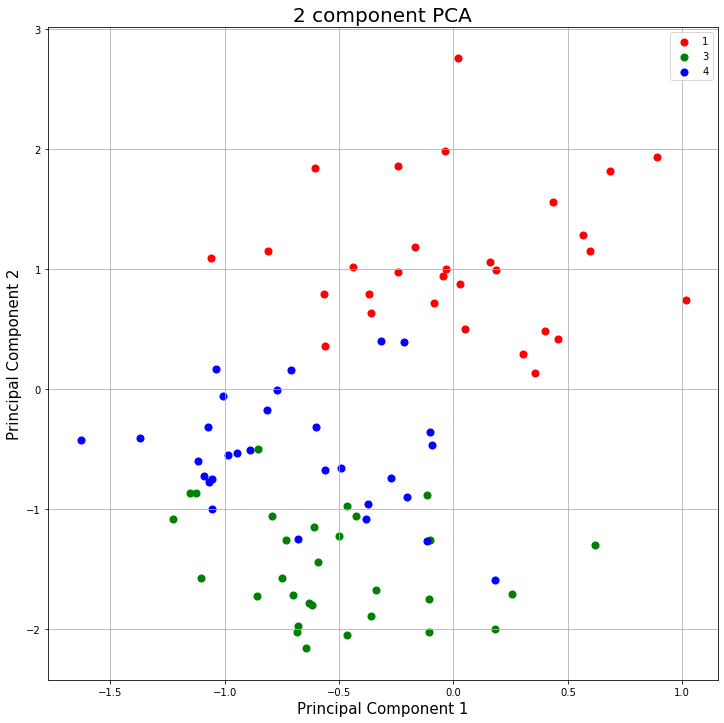

In [23]:
pca = PCA(n_components=2)
pca.fit(train_Resampled_26_2D)

# Prints PCA plot (Does only work with a PCA with 2 components)
# Code based on https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
principalComponents = pca.fit_transform(train_Resampled_26_2D)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, pd.DataFrame(Outputs)], axis = 1)
#print(finalDf)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
# Choose the speakers that you want to visualize in the plot
targets = [1, 3, 4]
colors = 'r', 'g', 'b'
# Uncomment if you want to visualize all speakers
#targets = [1,2,3,4,5,6,7,8,9]
#colors = ['r', 'g', 'b', 'k', 'c', 'm', 'y', 'tab:orange', 'tab:brown']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()

## Data reduction & visualisation with UMAP

In [24]:
# Data Reduction with UMAP
# pip3 install umap-learn
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sys

# Installing didn't work on my machine, so I provided tha path manually
sys.path.append('/Users/lauridsstockert/opt/anaconda3/lib/python3.7/site-packages')

import umap

sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

In [25]:
def umapCalc(input_data, n_neighbors, n_components, min_dist):
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components = n_components, min_dist = min_dist)
    embedding = reducer.fit_transform(input_data)
    return embedding

def drawUmap(input_data, input_labels, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(input_data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=input_labels)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=input_labels)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=input_labels, s=100)
    if n_components > 3:
        print("ERROR: Cannot draw more than 3 dimensions")
    plt.title(title, fontsize=18)

In [26]:
# Trying Data Reduction with UMAP
# Results range can get as high as 77% (best try so far)
# I have commented out the code for parameter optimisation

#accuracy_padded_after = np.zeros(100)
######accuracy_padded_before = np.zeros(100)
#cnt = 1

#for n in (2, 5, 10, 20):
    #for d in (0.1, 0.2, 0.4):
        #for c in (2, 5):
            #accuracy_padded_after = np.zeros(100)
            #inputs_train_umap = umapCalc(trainInputsSquaredPost, n, c, d)
            #for i in range(100):
                #accuracy_padded_after[i] = predictLabels(inputs_train_umap, trainOutputsNew)
            #print("Params are n_neighbors(n), min_dist(d), and n_components(c) \n  n = {}, d = {}, c = {}".format(n, d, c))
            #print("Av. Accuracy (padding after)", np.mean(accuracy_padded_after))
            #print("\n")
            #cnt = cnt + 1
# empirically good combinations:
# Acc = 77%: n = 50, d = 0.99, c = 7
# Acc = 63.37%: n = 20, d = 0.8, c = 2

In [27]:
for n in (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12):
    pass
    #drawUmap(input_data = trainInputsSquaredPost, input_labels = trainOutputsNew, n_neighbors=n, n_components = 3, title='n_neighbors = {}'.format(n))

In [28]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    pass
    #drawUmap(input_data = trainInputsSquaredPost, input_labels = trainOutputsNew, min_dist=d, title='min_dist = {}'.format(d))

## LSTM classifier implementation

In [29]:
#for those packages install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional
from keras.layers import Activation
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import GaussianDropout
from keras.preprocessing import sequence
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [30]:
def predictLabelsLSTM(trainInputs, trainOutputs, epochs_option, optimizer_option, dropout_option):
    inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputs, trainOutputs)
    
    inputs_train = np.asarray(inputs_train).astype('float32')
    inputs_test = np.asarray(inputs_test).astype('float32')
    outputs_train = np.asarray(outputs_train).astype('float32')
    outputs_test = np.asarray(outputs_test).astype('float32')
    #choose embedding length that is equal to the amount of dimensions
    #embedding_vecor_length = 13
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = inputs_train[0])))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_option))
    model.add(Bidirectional(LSTM(units = 100)))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_option, metrics=['accuracy'])
    
    model.fit(inputs_train, outputs_train, epochs=epochs_option, batch_size=4, verbose=0)
    
    scores = model.evaluate(inputs_test, outputs_test, verbose=0)

    return scores[1]*100


iterations = 10

#sampleNum = 26
#for data in train3D:
    #accuracy_train = np.zeros(no_iterations)
    #for i in range(iterations):
        #accuracy_train = predictLabelsLSTM(data, trainOutputsNew)
    #print("Accuracy for {} size arrays: {}".format(sampleNum, np.mean(accuracy_train)))
    #sampleNum = sampleNum - 1

# LSTM Gridsearch

In [31]:
EpochTimes = [ 10, 15, 20]
Optimizers = ['adamax','sgd', 'adagrad']
Resamples = [train_Resampled_14, train_Resampled_20, train_Resampled_26]
Dropouts = [ 0.1, 0.2, 0.3]

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

iterations = 10
#for epochs in EpochTimes:
    #for optimizer in Optimizers:
        #for sample in Resamples:
            #for dropout in Dropouts:
                #accuracies = np.zeros(iterations)
                #for i in range(iterations):
                    #accuracies[i] = predictLabelsLSTM(sample, trainOutputsNew, epochs, optimizer, dropout)
                #print("Length", len(sample[0]), "; Optimizer", optimizer, "; Epochs", epochs, "; Dropout", dropout, "; Accuracy", np.mean(accuracies))

# LSTM Ensemble creation

In [32]:
def makeLSTM_Model(inputs_train, outputs_train, optimizer_option, epochs_option, dropout_option):
    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = inputs_train[0])))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_option))
    model.add(Bidirectional(LSTM(units = 100)))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_option, metrics=['accuracy'])
    #print(model.summary())
    model.fit(inputs_train, outputs_train, epochs=epochs_option, batch_size=4, verbose=0)
    
    return model

In [33]:
from sklearn.metrics import accuracy_score

""" Creates ensemble classifier with our best performing classifiers"""
# Code based on code from assignment of IDS.


def createEnsembleLSTM(inputs_train, outputs_train):
    ensemble = list()
    c1 = makeLSTM_Model(inputs_train, outputs_train, 'adamax', 10, 0.1)
    ensemble.append(c1)
    c2 = makeLSTM_Model(inputs_train, outputs_train, 'adamax', 10, 0.2)
    ensemble.append(c2)
    c3 = makeLSTM_Model(inputs_train, outputs_train, 'adamax', 15, 0.3)
    ensemble.append(c3)
    c4 = makeLSTM_Model(inputs_train, outputs_train, 'adamax', 20, 0.1)
    ensemble.append(c4)
    c5 = makeLSTM_Model(inputs_train, outputs_train, 'adamax', 20, 0.2)
    ensemble.append(c5)
    c6 = makeLSTM_Model(inputs_train, outputs_train, 'adamax', 20, 0.3)
    ensemble.append(c6)
    c7 = makeLSTM_Model(inputs_train, outputs_train, 'adagrad', 15, 0.1)
    ensemble.append(c7)
    c8 = makeLSTM_Model(inputs_train, outputs_train, 'adagrad', 15, 0.2)
    ensemble.append(c8)
    c9 = makeLSTM_Model(inputs_train, outputs_train, 'adagrad', 20, 0.1)
    ensemble.append(c9)
    c10 = makeLSTM_Model(inputs_train, outputs_train, 'adagrad', 20, 0.2)
    ensemble.append(c10)
    c11 = makeLSTM_Model(inputs_train, outputs_train, 'adagrad', 20, 0.3)
    ensemble.append(c11)
    
    return ensemble

""" Returns prediction from ensemble classifier"""   
def ensemblePredictLSTM(inputs_train, outputs_train, inputs_test):
    ensemble = createEnsembleLSTM(inputs_train, outputs_train)
    
    # Predict the test data
    yhats = [model.predict(inputs_test) for model in ensemble]
    yhats = np.array(yhats)
    # sum across ensembles
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    outcomes = np.argmax(summed, axis=1)
    
    
    return outcomes


def predictLabelsLSTM(inputs_train, outputs_train, inputs_test, outputs_test):
    
    inputs_train = np.asarray(inputs_train).astype('float32')
    inputs_test = np.asarray(inputs_test).astype('float32')
    outputs_train = np.asarray(outputs_train).astype('float32')
    outputs_test = np.asarray(outputs_test).astype('float32')

    # Predict the test labels
    prediction = ensemblePredictLSTM(inputs_train, outputs_train, inputs_test)
    

    return accuracy_score(outputs_test, prediction)

In [34]:
accuracy_Ensemble = np.zeros(10)

for i in range(10):
    pass
    #accuracy_Ensemble[i] = predictLabelsLSTM(train_Resampled_26, trainOutputsNew, test_Resampled_26, testOutputsNew)

#accuracy_26 = predictLabelsLSTM(train_Resampled_26, trainOutputsNew, test_Resampled_26, testOutputsNew)
#accuracy_22 = predictLabelsLSTM(train_Resampled_22, trainOutputsNew)
#accuracy_18 = predictLabelsLSTM(train_Resampled_18, trainOutputsNew)
#accuracy_14 = predictLabelsLSTM(train_Resampled_14, trainOutputsNew)
#print("Accuracy_26:", np.mean(accuracy_Ensemble))
#print("Accuracy_22:", accuracy_22)
#print("Accuracy_18:", accuracy_18)
#print("Accuracy_14:", accuracy_14)

In [35]:
iterations = 1
accuracy_something = np.zeros(iterations)
for i in range(iterations):
    pass
    #accuracy_something[i] = predictLabelsLSTM(train3D[0], trainOutputsNew)
#print("Accuracy: ", np.mean(accuracy_something))

In [85]:
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

def predictLabelsLSTM_train(inputs_train, outputs_train):
    
    inputs_train = np.asarray(inputs_train).astype('float32')
    outputs_train = np.asarray(outputs_train).astype('float32')

    inputs_train, outputs_train = shuffle(inputs_train, outputs_train)

    model = Sequential()
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = inputs_train[0])))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units = 100)))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])
    
    history = model.fit(inputs_train, outputs_train, validation_split=0.2, epochs=30, batch_size=4, verbose = 0)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    #scores = model.evaluate(inputs_test, outputs_test, verbose=0)

    #return scores[1]*100

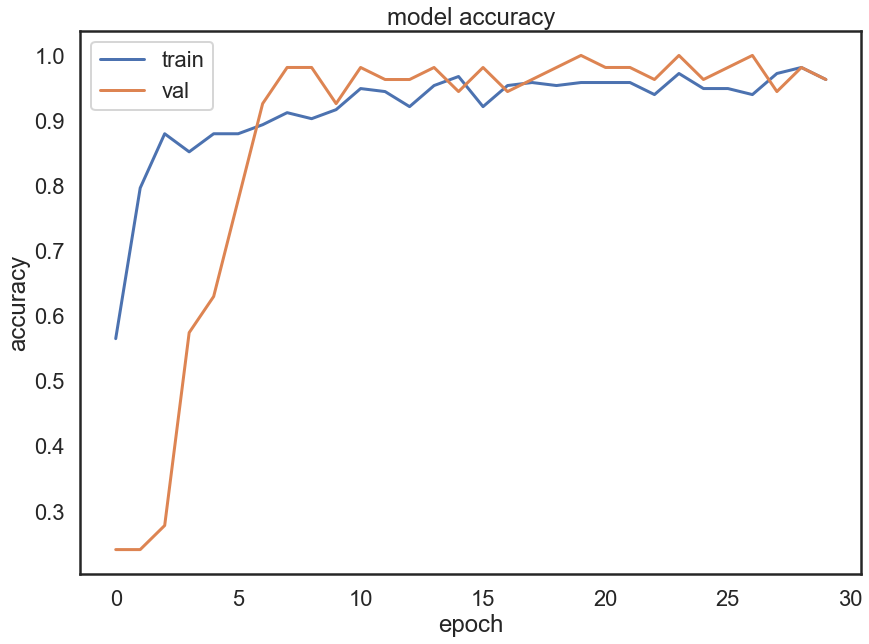

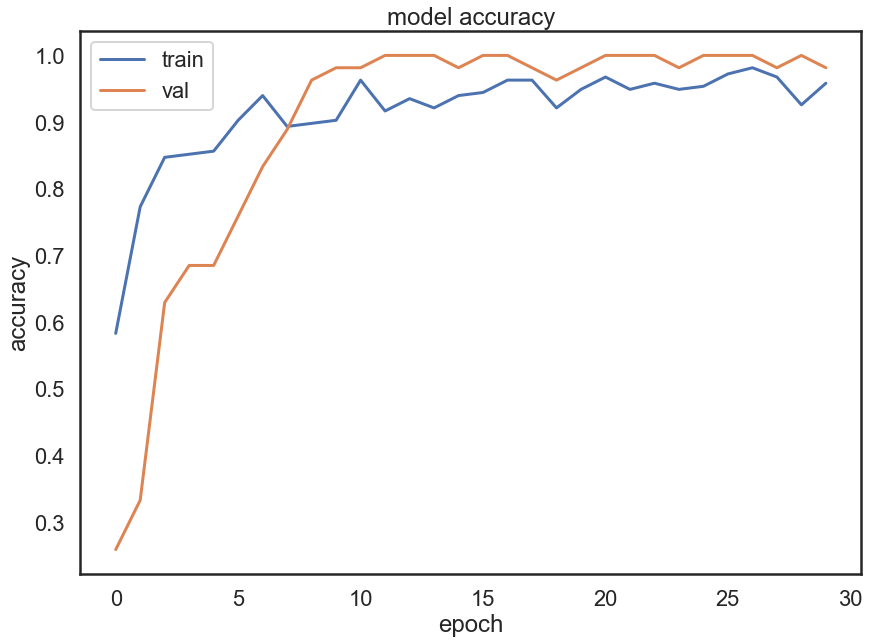

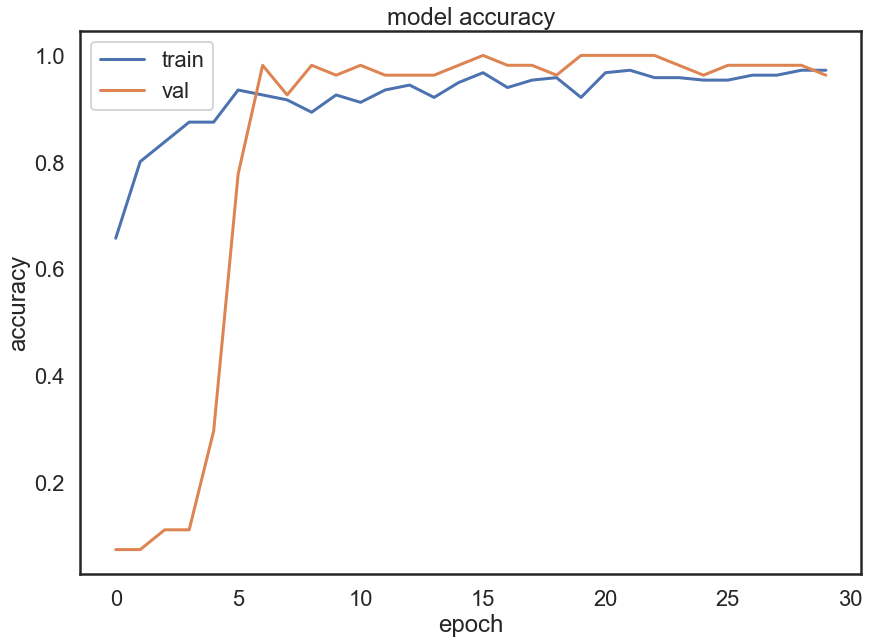

Test Accuracy: nan


In [86]:
no_iter = 3
test_accuracy = np.zeros(no_iter)

for j in range(no_iter):
    test_accuracy[j] = predictLabelsLSTM_train(train_Resampled_26, trainOutputsNew)
print("Test Accuracy:", np.mean(test_accuracy))

In [ ]:
stop

## ECHO classifier implementation

In [34]:
## Still need to check if 2D data array from before works with ECHO

In [35]:
print(trainOutputsNew)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9]


In [36]:
# Format data for ECHO implenetation
ECHO_Train_26 = train_Resampled_26_2D.reshape(7020, 13)

trainOutputsEcho = np.zeros((7020, 9))

for i in range (270):
    for j in range(26):
        trainOutputsEcho[i * 26 + j][trainOutputsNew[i] - 1] = 1

In [37]:
# train data
trainInputs_array = []
trainOutputs_array = []

for i in range(270):
    ndim = np.shape(trainInputs[i][0])[0]
    for j in range(ndim):
        trainInputs_array.append(trainInputs[i][0][j])
        trainOutputs_array.append(trainOutputs[i][0][j])

# test data        
testInputs_array = []
testOutputs_array = []

for i in range(370):
    ndim = np.shape(testInputs[i][0])[0]
    for j in range(ndim):
        testInputs_array.append(testInputs[i][0][j])
        testOutputs_array.append(testOutputs[i][0][j])
    
    
# data arrays used for ESN; all the timesteps with its 12 channels (dim) in each recording put into a list
trainInputs_array = np.asarray(trainInputs_array)     
trainOutputs_array = np.asarray(trainOutputs_array)

testInputs_array = np.asarray(testInputs_array)
testOutputs_array = np.asarray(testOutputs_array)

(5616, 13)
(5616, 9)
(1404, 13)
Mean test error:  0.0512281984962321
Mean training error: 0.21721077111960946


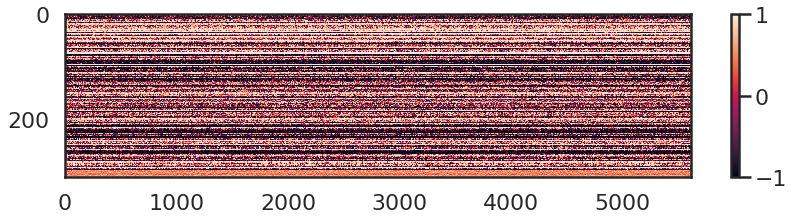

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from pyESN import ESN

esn = ESN(n_inputs = 13,
          n_outputs = 9,
          n_reservoir = 300,
          spectral_radius = 1.5,
          random_state=42)

# cross validation
inputs_train, inputs_test, outputs_train, outputs_test = splitData(ECHO_Train_26, trainOutputsEcho)

print(inputs_train.shape)
print(outputs_train.shape)
print(inputs_test.shape)

train_pred, mean_error_train = esn.fit(inputs_train, outputs_train, inspect=True)
test_pred = esn.predict(inputs_test)

print("Mean test error: ", np.mean((test_pred - outputs_test)**2))
print("Mean training error:", mean_error_train)

### Parameter optimization + cross validation

In [39]:
esn = ESN(n_inputs = 12,
          n_outputs = 9,
          random_state=42)

# parameter optimization

cv = RepeatedStratifiedKFold(n_splits=269, n_repeats=2, random_state=42)
param_grid = {"n_reservoir": [200, 400, 600, 800, 1000]}

clf = GridSearchCV(esn, param_grid)

m_scores = cross_val_score(esn, trainInputs, trainOutputs, cv=cv)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <pyESN.ESN object at 0x7ff66864bbb0> does not.